In [1]:
using LinearAlgebra, Plots
DEV = true
DEV && include("../src/LindbladEq.jl")
DEV ? using Main.LindbladEq : using LindbladEq

## Nearest-neighbor Hopping
We consider the Hamiltonian
$$
H = \sum_i c^\dagger_i c_{i+1} + h.c..
$$
There is two way to construct the Hamiltonian evolution. One is to exponentiate the whole Hamiltonian matrix, the other is the construct local gates using Trotter decomposition.

In [2]:
L = 1000
dt = 0.05
T = 100

# Fully Unitary
Ut = begin
    H = diagm(1 => ones(L-1), -1 => ones(L-1))
    evo_operator(Hermitian(H), dt)
end

# Gaussian Circuit
Circuit = begin
    h = [0 1;1 0]
    u = evo_operator(Hermitian(h), dt)
    layer1 = [Gate(u, [i, i+1]) for i in 1:2:L-1]
    layer2 = [Gate(u, [i, i+1]) for i in 2:2:L-1]
    layer1, layer2
end

# Initialize two identical states
psi1 = FreeFermionState(;L, N=L÷2, config="left")
psi2 = deepcopy(psi1)

# Simulate evolution, compute carge transport and entaglement entropy.
ts = 0:dt:T 
charge = zeros(1+length(ts)÷20, 2)
entropy = zeros(1+length(ts)÷20, 2)

# ~ 42s
@time for i in 2:length(ts)
    apply!(Ut, psi1)
    iszero(mod(i,20)) || continue
    charge[1+i÷20, 1] = sum(diag(psi1)[L÷2+1:L])
    entropy[1+i÷20, 1] = ent_S(psi1, 1:L÷2)
end

# ~ 26s
@time for i in 2:length(ts)
    apply!(Circuit[1], psi2)
    apply!(Circuit[2], psi2)
    iszero(mod(i,20)) || continue
    charge[1+i÷20, 2] = sum(diag(psi2)[L÷2+1:L])
    entropy[1+i÷20, 2] = ent_S(psi2, 1:L÷2)
end

 38.000567 seconds (376.85 k allocations: 17.228 GiB, 7.06% gc time, 0.40% compilation time)


 25.174748 seconds (5.06 M allocations: 62.427 GiB, 47.52% gc time, 23.53% compilation time)


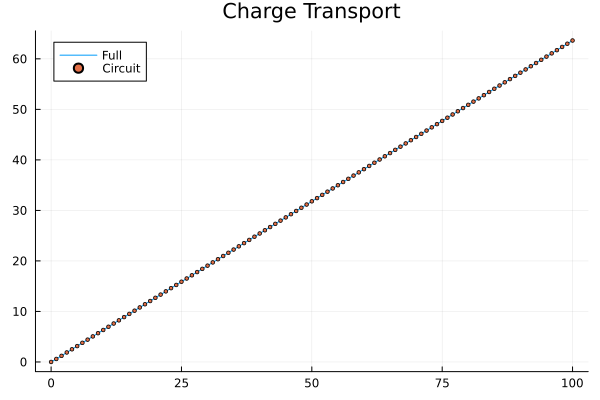

In [3]:
ts = 0:1:T
plot(ts, charge[:,1], label="Full")
scatter!(ts, charge[:,2], label="Circuit",markersize=2)
title!("Charge Transport")

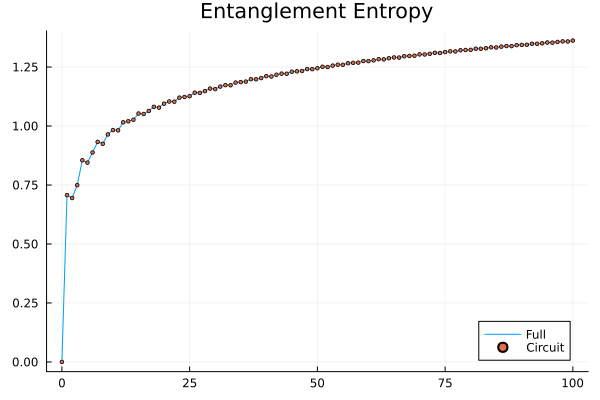

In [4]:
plot(ts, entropy[:,1], label="Full")
scatter!(ts, entropy[:,2], label="Circuit",markersize=2)
title!("Entanglement Entropy")